## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

In [2]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/data") 

## Fetching the cleaned dataset

In [4]:
df_new = pd.read_csv('/content/drive/MyDrive/Capstone/final_df.csv')

In [5]:
df_new.head()

,Frontal,Lateral,indication,findings,impression
0,1_IM-0001-4001.dcm.png,1_IM-0001-3001.dcm.png,positive tb test,the cardiac silhouette and mediastinum size ar...,normal chest x
1,2_IM-0652-1001.dcm.png,2_IM-0652-2001.dcm.png,preop bariatric surgery,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings
2,3_IM-1384-1001.dcm.png,3_IM-1384-2001.dcm.png,rib pain after a steps this pain to r back r e...,NaN,no displaced rib fractures pneumothorax or ple...
3,4_IM-2050-1001.dcm.png,4_IM-2050-2001.dcm.png,with,there are diffuse bilateral interstitial and a...,bullous emphysema and interstitial fibrosis p...
4,5_IM-2117-1003002.dcm.png,5_IM-2117-1004003.dcm.png,chest and nasal congestion,the cardiomediastinal silhouette and pulmonary...,no acute cardiopulmonary abnormality


In [6]:
df_new = df_new[['Frontal','Lateral','findings']]
df_new = df_new.rename(columns={'Frontal':'image1','Lateral':'image2','findings':'findings'})

In [7]:
df_new.head()

,image1,image2,findings
0,1_IM-0001-4001.dcm.png,1_IM-0001-3001.dcm.png,the cardiac silhouette and mediastinum size ar...
1,2_IM-0652-1001.dcm.png,2_IM-0652-2001.dcm.png,borderline cardiomegaly midline sternotomy enl...
2,3_IM-1384-1001.dcm.png,3_IM-1384-2001.dcm.png,NaN
3,4_IM-2050-1001.dcm.png,4_IM-2050-2001.dcm.png,there are diffuse bilateral interstitial and a...
4,5_IM-2117-1003002.dcm.png,5_IM-2117-1004003.dcm.png,the cardiomediastinal silhouette and pulmonary...


In [8]:
df_new.shape


(3903, 3)

In [9]:
df_new.isnull().sum()

image1        0
image2        0
findings    523
dtype: int64

In [10]:
df_new = df_new.dropna()

In [11]:
df_new.shape

(3380, 3)

In [12]:
3903- 3380

523

## Cleaning text 

In [13]:
import re
def decontraction(phrase):
# specific
  phrase = re.sub(r"won\ 't","will not", phrase)
  phrase = re.sub(r"can\ 't","can not", phrase)
# general
  phrase = re.sub(r"n\'t"," not", phrase)
  phrase = re.sub(r"'\re"," are", phrase)
  phrase = re.sub(r"\'s"," is",phrase)
  phrase = re.sub(r"\'d"," would",phrase)
  phrase = re.sub(r"\'ll"," will",phrase)
  phrase = re.sub(r"\'t"," not",phrase)
  phrase = re.sub(r"\'ve"," have",phrase)
  phrase = re.sub(r"\'m"," am",phrase)
  return phrase

In [14]:
for i in tqdm(range(0,df_new.shape [0])):
  text = re.sub(r'(\s\d+)', "", df_new.iloc[i]. loc['findings'])
  text = text.lower ()
  text = re.sub(r'[^a-z]',' ',text)
  text = text.strip("")
  text = decontraction(text)
  df_new.iloc[i].loc['findings'] = text

100%|██████████| 3380/3380 [00:00<00:00, 5290.68it/s]


In [15]:
for i in tqdm(range(0,df_new.shape [0])):
  text = re.sub(r'\b\w{,1/\b','',df_new.iloc[i].loc['findings'])
  text = text.strip(" ")
  df_new.iloc[i].loc['findings']= re.sub(r'\s\s+'," ", text)

100%|██████████| 3380/3380 [00:00<00:00, 5883.65it/s]


In [16]:
df_new.head()

,image1,image2,findings
0,1_IM-0001-4001.dcm.png,1_IM-0001-3001.dcm.png,the cardiac silhouette and mediastinum size ar...
1,2_IM-0652-1001.dcm.png,2_IM-0652-2001.dcm.png,borderline cardiomegaly midline sternotomy enl...
3,4_IM-2050-1001.dcm.png,4_IM-2050-2001.dcm.png,there are diffuse bilateral interstitial and a...
4,5_IM-2117-1003002.dcm.png,5_IM-2117-1004003.dcm.png,the cardiomediastinal silhouette and pulmonary...
5,6_IM-2192-1001.dcm.png,6_IM-2192-2001.dcm.png,heart size and mediastinal contour are within ...


## Preparing the text by adding 'start' and 'end' to the text

In [17]:
df = df_new.copy()

In [18]:
for i in tqdm(range (0,df .shape [0])):
  df.iloc[i]['image 1'] = f"./{df.iloc[i]['image1']}.png"
  df.iloc[i]['image 2'] = f"./{df.iloc[i] ['image2']}.png"
  df.iloc[i]['findings'] = f"<start> {df.iloc[i]['findings'].strip()} <end>"
  

100%|██████████| 3380/3380 [00:03<00:00, 917.14it/s]


In [19]:
df.head ()

,image1,image2,findings
0,1_IM-0001-4001.dcm.png,1_IM-0001-3001.dcm.png,<start> the cardiac silhouette and mediastinum...
1,2_IM-0652-1001.dcm.png,2_IM-0652-2001.dcm.png,<start> borderline cardiomegaly midline sterno...
3,4_IM-2050-1001.dcm.png,4_IM-2050-2001.dcm.png,<start> there are diffuse bilateral interstiti...
4,5_IM-2117-1003002.dcm.png,5_IM-2117-1004003.dcm.png,<start> the cardiomediastinal silhouette and p...
5,6_IM-2192-1001.dcm.png,6_IM-2192-2001.dcm.png,<start> heart size and mediastinal contour are...


In [20]:
df.shape, df_new.shape

((3380, 3), (3380, 3))

In [21]:
df.head()

,image1,image2,findings
0,1_IM-0001-4001.dcm.png,1_IM-0001-3001.dcm.png,<start> the cardiac silhouette and mediastinum...
1,2_IM-0652-1001.dcm.png,2_IM-0652-2001.dcm.png,<start> borderline cardiomegaly midline sterno...
3,4_IM-2050-1001.dcm.png,4_IM-2050-2001.dcm.png,<start> there are diffuse bilateral interstiti...
4,5_IM-2117-1003002.dcm.png,5_IM-2117-1004003.dcm.png,<start> the cardiomediastinal silhouette and p...
5,6_IM-2192-1001.dcm.png,6_IM-2192-2001.dcm.png,<start> heart size and mediastinal contour are...


In [22]:

df['image1'] = df['image1'].apply(lambda x: "{}{}".format('/content/drive/MyDrive/data/aish_images.zip (Unzipped Files)/images/images_normalized/', x))
df['image2'] = df['image2'].apply(lambda x: "{}{}".format('/content/drive/MyDrive/data/aish_images.zip (Unzipped Files)/images/images_normalized/', x))

In [23]:
df['image1'][0]

'/content/drive/MyDrive/data/aish_images.zip (Unzipped Files)/images/images_normalized/1_IM-0001-4001.dcm.png'

In [24]:
med_report = []
image_path = []
for i in tqdm(range (0,df.shape [0])):
  image_path.append(df.iloc[i].loc['image1'])
  med_report.append(df.iloc[i].loc['findings'])
  image_path.append(df.iloc[i].loc['image2'])
  med_report.append(df.iloc[i].loc['findings'])


100%|██████████| 3380/3380 [00:00<00:00, 4569.25it/s]


In [25]:
train_captions = []
image_paths = []
train_captions = med_report
image_paths = image_path

## REFERECE : https://www.tensorflow.org/tutorials/text/image_captioning

APPROACH : Used an attention mechanism with encoder and decoder. The encoder passes image features through a Fully connected layer. The decoder generates captions for the features.

##  Initialize DenseNet121 and loading pretrained CheXNet weights

Instead of training the model from scratch, wer have used DenseNet121 with pretrained weights.(link: https://www.kaggle.com/datasets/theewok/chexnet-keras-weights)

In [26]:
chexnet_weights="/content/drive/MyDrive/Capstone/Medical Report Generation Using Deeplearning/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"
image_model = tf.keras.applications.densenet.DenseNet121(include_top=True, classes=14,weights=chexnet_weights)
new_input = image_model.input
hidden_layer = image_model. layers [-3].output
image_features_extract_model = tf.keras.Model(new_input,hidden_layer)
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

____________________________________________

In [27]:
# Function to read the image, decode and resize to (224,224).
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img,(224, 224))
  img = tf.keras.applications.densenet.preprocess_input(img)
  return img, image_path



## Creating Dataset and extracting features from images

In [28]:
# Get unique images
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

## Tokenizing the text data

In [29]:


# # Max word count for a caption.
# max_length = 50
# vocabulary_size = 12000
# tokenizer = tf.keras.layers.TextVectorization(
#     max_tokens=vocabulary_size,
#     output_sequence_length=max_length)
# # Learn the vocabulary from the caption data.
# tokenizer.adapt(caption_dataset)



caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# Max word count for a caption.
max_length = 50
vocabulary_size = 12000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [30]:

cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [31]:

## Create mappring for word to tokens and tokens to words 
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split data to training and testing in 90-10

In [32]:
## Split data to training and testing in 80-20
import collections
import random
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, cap_vector):
  img_to_cap_vector[img].append(cap)


img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.9)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [33]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(6093, 6093, 667, 667)

## Creating  dataset for training 

In [34]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 512
units = 1024
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2560
#attention_features_shape = 64
attention_features_shape = 49

In [35]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>

## Modeling - using Encoder, Decoder, and Attention models.


We created Encoder, Decoder, and Attention models using subclassing.

In [38]:
class CNN_Encoder(tf.keras.Model):
    # We will use already extracted the features 
    # This encoder passes those extracted features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [39]:
class Attention(tf.keras.Model):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)


    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))


    # this helps to give unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)


    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

The decoder model has one Embedding layer, one GRU layer, and two dense layers.

In [40]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = Attention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

## Training the model 

In [41]:
# created the encoder and decoder objects
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [42]:
#  optimizer as Adam and loss_object as SparseCategoricalCrossentropy
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [43]:
# checkpoint_path = "./checkpoints/train"
# ckpt = tf.train.Checkpoint(encoder=encoder,
#                            decoder=decoder,
#                            optimizer=optimizer)
# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [44]:
start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   # restoring the latest checkpoint in checkpoint_path
#   ckpt.restore(ckpt_manager.latest_checkpoint)

In [45]:
loss_plot = []

In [46]:
# this is tensor function.
#The extracted feature i.e image tensor is passed to encoder.
# decoder returns the predictions used to calculate loss and the decoder’s hidden state

@tf.function
def train_step(img_tensor, target):
  loss = 0


  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # pass the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

  
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [47]:
EPOCHS = 30

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    
    loss_plot.append(total_loss / num_steps)

    # if epoch % 5 == 0:
    #   ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 4.8303
Epoch 1 Loss 2.627447
Time taken for epoch 541.42 sec

Epoch 2 Batch 0 Loss 1.8805
Epoch 2 Loss 1.663944
Time taken for epoch 32.06 sec

Epoch 3 Batch 0 Loss 1.6604
Epoch 3 Loss 1.444487
Time taken for epoch 32.49 sec

Epoch 4 Batch 0 Loss 1.2934
Epoch 4 Loss 1.326788
Time taken for epoch 32.81 sec

Epoch 5 Batch 0 Loss 1.0515
Epoch 5 Loss 1.238621
Time taken for epoch 33.13 sec

Epoch 6 Batch 0 Loss 1.1456
Epoch 6 Loss 1.178971
Time taken for epoch 33.44 sec

Epoch 7 Batch 0 Loss 1.0398
Epoch 7 Loss 1.124893
Time taken for epoch 33.42 sec

Epoch 8 Batch 0 Loss 1.1886
Epoch 8 Loss 1.077724
Time taken for epoch 33.51 sec

Epoch 9 Batch 0 Loss 1.0632
Epoch 9 Loss 1.040728
Time taken for epoch 33.65 sec

Epoch 10 Batch 0 Loss 0.9731
Epoch 10 Loss 1.002199
Time taken for epoch 33.69 sec

Epoch 11 Batch 0 Loss 1.0172
Epoch 11 Loss 0.973537
Time taken for epoch 33.62 sec

Epoch 12 Batch 0 Loss 1.0113
Epoch 12 Loss 0.937209
Time taken for epoch 33.72 sec

Epoch 13 

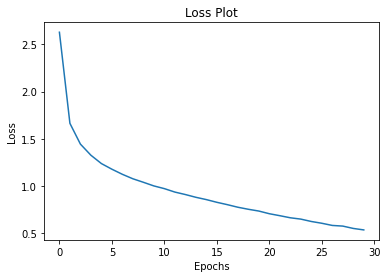

In [48]:
# plot the loss
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [49]:
temp_input = tf.expand_dims(load_image('/content/drive/MyDrive/Capstone/Medical Report Generation Using Deeplearning/NLMCXR_png/CXR2957_IM-1354-1003.png')[0], 0)
temp_input

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[-1.7456235 , -1.655124  , -1.4255457 ],
         [-1.9461977 , -1.8601753 , -1.6296856 ],
         [-2.037547  , -1.9535636 , -1.7226589 ],
         ...,
         [-2.0665298 , -1.9831933 , -1.7521569 ],
         [-2.031797  , -1.9476851 , -1.7168065 ],
         [-2.012739  , -1.9282017 , -1.6974097 ]],

        [[-1.975874  , -1.8905139 , -1.6598893 ],
         [-2.112285  , -2.0299697 , -1.7987255 ],
         [-2.117904  , -2.0357141 , -1.8044444 ],
         ...,
         [-2.0665298 , -1.9831933 , -1.7521569 ],
         [-2.0623603 , -1.9789307 , -1.7479132 ],
         [-2.031147  , -1.9470206 , -1.716145  ]],

        [[-1.9491029 , -1.8631452 , -1.6326424 ],
         [-2.0971096 , -2.0144558 , -1.7832804 ],
         [-2.117904  , -2.0357141 , -1.8044444 ],
         ...,
         [-2.070199  , -1.9869443 , -1.7558913 ],
         [-2.0481815 , -1.9644355 , -1.7334825 ],
         [-2.0151556 , -1.9306722 , -1.6998693

## Evaluation and Results

In [50]:
def evaluate(image):

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())


        

        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [51]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(200, 200))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (80, 80))
        grid_size = max(int(np.ceil(len_result/2)), 1)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    # plt.tight_layout()
    plt.show()

In [52]:
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# img = plt.imread(image)
# plt.figure()
# plt.imshow(img, cmap = "gray")
# plt.axis(False)
# real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
#                          for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate(image)

# print('Real Caption:', real_caption)
# print('Prediction Caption:', ' '.join(result))
# # plot_attention(image, result, attention_plot)

The model is giving decent reports for the chest X-ray images.

BLEU Score

In [53]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

chencherry = SmoothingFunction()


In [56]:
index=len(img_name_val)
cols = ['image', 'real','pred','blue']
dat = pd.DataFrame(columns = cols)
bl=0
bl_avg = 0
nums= len(img_name_val)
df_predicted_res = pd.DataFrame()
for j in range(nums):
  # captions on the validation se
  # rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[j]
  real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[j] if i not in [0]]
  
  result, attention_plot = evaluate(image)

  rem = ['startseq', 'start', 'end', 'endseq']
  real_caption  = [x for x in real_caption if x not in rem]
  result  = [x for x in result if x not in rem]
  
  print('Real cap: ', ' '.join([i for i in real_caption]))
  print('Predicted cap: ', ' '.join(result))
  
  chencherry = SmoothingFunction()
  bl=sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=chencherry.method5)
  print(bl)
  real_cap =  ' '.join([i for i in real_caption])
  pred_cap = ' '.join(result)
  dat = dat.append({'image': image, 'real':real_cap,'pred':pred_cap,'blue':bl},ignore_index=True)
  print('*'*100)
  #bl_avg+=sentence_bleu(real_caption,result)
#print("average bleu score on the test data is ",bl_avg/nums)
#dat.to_csv('/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/Aish_real_vs_predicted.csv')

Real cap:  low lung volumes with bibasilar subsegmental atelectasis no focal consolidations pleural effusions or pneumothoraces cardiomediastinal silhouette is within normal limits degenerative changes of the thoracic spine
Predicted cap:  ap view is lordotic frontal projection mild cardiomegaly remains slightly large calcified right mid lung are clear bilaterally specifically no evidence of focal consolidation pneumothorax or pleural effusions seen along the lung bases representing foci of subsegmental atelectasis no fracture or subsegmental atelectasis at the peripheral aspect of the right
0.26567810564605926
****************************************************************************************************
Real cap:  the trachea is midline negative for pneumothorax pleural effusion or focal airspace consolidation the heart size is normal
Predicted cap:  lungs are clear without focal consolidation no suspicious pulmonary opacity pneumothorax or pleural effusion the heart and mediast

# NER

In [57]:

## Install scispaCy models
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_craft_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_jnlpba_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bionlp13cg_md-0.4.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz (15.6 MB)
  Using cached spacy-3.0.9-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.0 MB)
  Using cached thinc-8.0.17-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (671 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.5
    Uninstalling thinc-8.1.5:
      Successfully uninstalled thinc-8.1.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.4
    Uninstalling spacy-3.4.4:
      Successfully uninstalled spacy-3.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scispacy 0.5.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.0.9 which is incompatible.
en-core-web-sm 3.4.1 requires 

In [58]:

!pip install -U spacy
!pip install scispacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached spacy-3.4.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.6 MB)
  Using cached thinc-8.1.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (819 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.0.9
    Uninstalling spacy-3.0.9:
      Successfully uninstalled spacy-3.0.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-ner-jnlpba-md 0.4.0 requires spacy<3.1.0,>=3.0.1, but you have spacy 3.4.4 which is incompatible.
en-ner-craft-md 0.4.0 requires spacy<3.1.0,>=3.0.1, but you have spacy 3.4.4 which is incompatible.
en-ner-bionlp13cg-md 0.4.0 requires spac

In [59]:

import scispacy
import spacy

#Core models
import en_core_sci_sm
import en_core_sci_lg

#NER specific models
import en_ner_craft_md
import en_ner_bc5cdr_md
import en_ner_jnlpba_md
import en_ner_bionlp13cg_md

#Tools for extracting & displaying data
from spacy import displacy

In [60]:

def display_NER(result):
  nlp = en_ner_bc5cdr_md.load()
  doc = nlp(result)
  #Display resulting entity extraction
  displacy_image = displacy.render(doc, jupyter=True,style='ent')
  print("TEXT", "START", "END", "ENTITY TYPE")
  for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

def pipeline_NER(result):
  nlp_en = en_ner_bc5cdr_md.load()
  nlp_xx = en_ner_bionlp13cg_md.load()
  nlp_en.add_pipe("ner", name="ner_xx", source=nlp_xx)
  doc = nlp_en(result)
  displacy_image = displacy.render(doc, jupyter=True,style='ent')
  print("TEXT", "START", "END", "ENTITY TYPE")
  for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

rid 466
bleu score is  0.02935665821292112
Real report:  low lung volumes with streaky bibasilar opacities right greater than left bronchovascular crowding indistinct central vascular margination no findings to suggest pleural effusion accounting for technical factors heart size within normal limits
Predicted report:  cardiomediastinal silhouette is normal there are calcified hilar lymph there are minimal degenerative changes of the midlower thoracic vertebral bodies are grossly unremarkable ankle soft tissue attenuation there are degenerative changes of the spine


TEXT START END ENTITY TYPE
soft tissue 183 194 TISSUE
spine 245 250 IMMATERIAL_ANATOMICAL_ENTITY


TEXT START END ENTITY TYPE


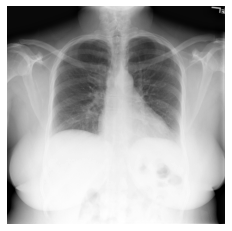

In [61]:

rid = np.random.randint(0, len(img_name_val))
print('rid', rid)
image = img_name_val[rid]
img = plt.imread(image)
plt.figure()
plt.imshow(img, cmap = "gray")
plt.axis(False)
real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]]
result, attention_plot = evaluate(image)
rem = ['startseq', 'start', 'end', 'endseq']
real_caption  = [x for x in real_caption if x not in rem]
result  = [x for x in result if x not in rem]
bl=sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=chencherry.method3)
print("bleu score is ",bl)
print('Real report: ', ' '.join([i for i in real_caption]))
print('Predicted report: ', ' '.join(result))
pipeline_NER(' '.join(result))
display_NER(' '.join(result))
# plot_attention(image, result, attention_plot)
     

Average

In [ ]:


index=len(img_name_val)
cols = ['image', 'real','pred','blue']
dat = pd.DataFrame(columns = cols)
bl=0
df_predicted_res = pd.DataFrame()
nums= 10
for j in range(nums):

  image = img_name_val[j]
  real_caption = [tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[j] if i not in [0]]
  
  result, attention_plot = evaluate(image)
  #removing the start and end tags we initially added
  rem = ['startseq', 'start', 'end', 'endseq']
  real_caption  = [x for x in real_caption if x not in rem]
  result  = [x for x in result if x not in rem]
  
  print('Real report: ', ' '.join([i for i in real_caption]))
  print('Predicted report: ', ' '.join(result))

  chencherry = SmoothingFunction()
  bl+=sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=chencherry.method5)
  print('Bleu score: ', sentence_bleu([result], real_caption,weights=(1, 0, 0, 0), smoothing_function=chencherry.method3))
  real_cap =  ' '.join([i for i in real_caption])
  pred_cap = ' '.join(result)
  dat = dat.append({'image': image, 'real':real_cap,'pred':pred_cap,'blue':bl},ignore_index=True)
  pipeline_NER(' '.join(result))
  display_NER(' '.join(result))
  print('*'*100)
print("average bleu score on the test data is ",bl/nums)


Real report:  low lung volumes with bibasilar subsegmental atelectasis no focal consolidations pleural effusions or pneumothoraces cardiomediastinal silhouette is within normal limits degenerative changes of the thoracic spine
Predicted report:  low lung volumes cardiomegaly no pneumothorax or definite pleural effusion seen the lateral view no definite focal alveolar consolidation no findings of soft tissue attenuation there are degenerative changes of the thoracic spine there is increased bilateral interstitial opacity seen partially due to low lung volumes causing mild
Bleu score:  0.23103338512321234


TEXT START END ENTITY TYPE
low lung volumes 0 16 DISEASE
cardiomegaly 17 29 DISEASE
pneumothorax 33 45 DISEASE
pleural effusion 58 74 DISEASE
lateral 84 91 ORGANISM_SUBDIVISION
focal alveolar 109 123 TISSUE
soft tissue 153 164 TISSUE
thoracic spine 215 229 MULTI_TISSUE_STRUCTURE
interstitial opacity 259 279 DISEASE
lung 306 310 ORGAN


TEXT START END ENTITY TYPE
low lung volumes 0 16 DISEASE
cardiomegaly 17 29 DISEASE
pneumothorax 33 45 DISEASE
pleural effusion 58 74 DISEASE
interstitial opacity 259 279 DISEASE
****************************************************************************************************
Real report:  the trachea is midline negative for pneumothorax pleural effusion or focal airspace consolidation the heart size is normal
Predicted report:  normal heart size and mediastinal contours no abnormal airspace opacities no pneumothorax or effusions or parenchymal consolidations heart size normal cardiomediastinal silhouette is normal in size and contour there are no acute bony findings demonstrated
Bleu score:  0.1512371637735867


TEXT START END ENTITY TYPE
heart 7 12 ORGAN
mediastinal contours 22 42 PATHOLOGICAL_FORMATION
abnormal airspace opacities 46 73 DISEASE
pneumothorax 77 89 DISEASE
effusions 93 102 CANCER
parenchymal 106 117 TISSUE
heart 133 138 ORGAN


TEXT START END ENTITY TYPE
abnormal airspace opacities 46 73 DISEASE
pneumothorax 77 89 DISEASE
****************************************************************************************************
Real report:  the and soft tissue appear normal the cardiac silhouette and mediastinum size are normal the aortic is on the left the trachea is well seen and appears normal the lungs are clear
Predicted report:  the examination consists of frontal and lateral radiographs of the chest the heart silhouette and cardiomediastinal silhouette in size and contour aortic appear unremarkable lungs demonstrate no acute findings there is no effusion or pneumothorax within normal limits for size and contour mediastinal contour normal tortuous aorta normal
Bleu score:  0.2843112467402969


TEXT START END ENTITY TYPE
frontal 28 35 MULTI_TISSUE_STRUCTURE
chest 67 72 ORGAN
heart 77 82 ORGAN
aortic 147 153 ORGAN
lungs 174 179 ORGAN
pneumothorax 234 246 DISEASE
aorta 325 330 MULTI_TISSUE_STRUCTURE


TEXT START END ENTITY TYPE
pneumothorax 234 246 DISEASE
****************************************************************************************************
Real report:  the heart and lungs have in the interval both lungs are clear and expanded heart and mediastinum normal
Predicted report:  the heart and lungs have in the interval both lungs are clear and expanded heart and mediastinum normal secondary to obscuration of the heart in the right th rib demonstrated in the mid abdomen the lungs are clear bilaterally without infiltrate there is no effusion or pneumothorax
Bleu score:  0.19966564006790186


TEXT START END ENTITY TYPE
heart 4 9 ORGAN
lungs 14 19 ORGAN
lungs 46 51 ORGAN
heart 75 80 ORGAN
mediastinum 85 96 ORGAN
heart 136 141 ORGAN
rib 158 161 ORGAN
abdomen 186 193 ORGAN
lungs 198 203 ORGAN
pneumothorax 269 281 DISEASE


TEXT START END ENTITY TYPE
pneumothorax 269 281 DISEASE
****************************************************************************************************
Real report:  the lungs are hyperexpanded with increased ap diameter of the chest the cardiomediastinal silhouette is stable and normal there is no pneumothorax or large pleural effusion
Predicted report:  there is obscuration of the left lung base the remainder of the heart also present no evidence for displaced clavicle interval bibasilar interstitial infiltrates and a large rounded lucency in the lung bases these are blunted there does not appear to be significant mediastinal shift there is a large amount
Bleu score:  0.1680862248144163


TEXT START END ENTITY TYPE
lung 33 37 ORGAN
heart 64 69 ORGAN
clavicle interval bibasilar interstitial infiltrates 109 161 DISEASE
lung 197 201 ORGAN
mediastinal 266 277 ORGAN


TEXT START END ENTITY TYPE
clavicle interval bibasilar interstitial infiltrates 109 161 DISEASE
****************************************************************************************************
Real report:  the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size the lungs are mildly hypoinflated but grossly clear of focal airspace disease pneumothorax or pleural effusion there are mild degenerative endplate changes in the thoracic spine there are no acute bony findings
Predicted report:  chest heart size and pulmonary vascularity appear within normal limits the are unremarkable there are cholecystectomy clips evidence of bowel measuring approximately cm above the neck addition grossly stable low lung volumes bibasilar opacities triangular density projected over the inferior in the mid onethird of the th posterior better
Bleu score:  0.3042894792001104
